# Sentiment Analysis

## --- Define the Problem ---

I will be examining tweets about airlines that reflect either good, neutral, or bad sentiment towards the airline. This has high practical importance to companies as it would allow them to automatically detect both good and bad feedback from a variety of sources (tweets, reviews, facebook, etc.) and potentially either respond to individual negative criticisms or enact changes if there is a pattern in the negative feedback. The goal is to develop a model that can accurately predict the sentiment of said tweets in order to provide a starting point for customer service intervention or policy change.

## Load the Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from EDAhelperfunctions import *

In [2]:
df = pd.read_csv('data/twitter-airline-sentiment/Tweets.csv')

## --- EDA ---

In [3]:
basic_eda(df)

The dataframe:
              tweet_id airline_sentiment  airline_sentiment_confidence  \
0  570306133677760513           neutral                        1.0000   
1  570301130888122368          positive                        0.3486   
2  570301083672813571           neutral                        0.6837   
3  570301031407624196          negative                        1.0000   
4  570300817074462722          negative                        1.0000   

  negativereason  negativereason_confidence         airline  \
0            NaN                        NaN  Virgin America   
1            NaN                     0.0000  Virgin America   
2            NaN                        NaN  Virgin America   
3     Bad Flight                     0.7033  Virgin America   
4     Can't Tell                     1.0000  Virgin America   

  airline_sentiment_gold        name negativereason_gold  retweet_count  \
0                    NaN     cairdin                 NaN              0   
1               

There is a lot of information here! Each instance is a tweet that has a text, location, sentiment, and other information about name, retweets, airline, etc.

Some of these columns seem unrelated to the base goal. Since our goal is to predict sentiment based on the text of the tweet, information such as timezone, location, time of tweet should likely be removed during cleaning. We also see that a confidence level is assigned to the sentiment of each tweet; it may be wise to discard instances that have very low confidence as it is possible that these instances are not correct and will mislead the model. We could also give each instance a weight based on its confidence. Retweets are potentially useful to order tweets by popularity and therefore importance.

Some columns are mostly null and should be dropped. It seems that the most important columns such as sentiment and text have no null values which is good. I will split out the negative reason and confidence columns as this is a secondary classification task that can be added in once I have achieved the primary goal of a sentiment classifier.

There are 36 duplicate instances but they may actually be valid data points. For instance, there are 6 instances of the text @united thanks, which may be 6 valid instances. We will examine duplicates closely.

All columns appear to be appropriate data types.

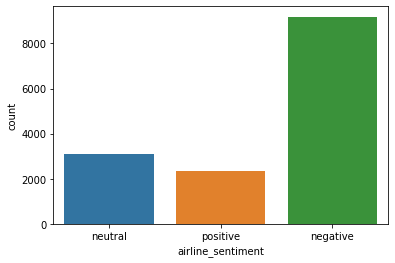

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [4]:
import os

if not(os.path.exists('figures')):
    os.mkdir('figures')

fig = plt.figure()
sns.countplot(x='airline_sentiment', data=df)
plt.show()
fig.savefig('figures/sentiment_labels.png')

df.head()

We have many more instances of the negative class, which makes sense as people are most likely to speak out when they have had a strong negative experience. 

In [5]:
print(len(max(df['text'], key=len)))
print(min(df['text'], key=len))

186
@united done


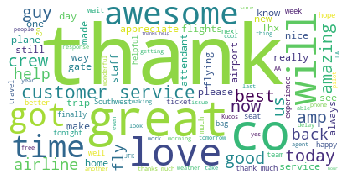

In [6]:
from wordcloud import WordCloud, STOPWORDS

pos = df.loc[df['airline_sentiment'] == 'positive']
neut = df.loc[df['airline_sentiment'] == 'neutral']
neg = df.loc[df['airline_sentiment'] == 'negative']

pos_text = ''.join([tweet for tweet in pos['text']])
neut_text = ''.join([tweet for tweet in neut['text']])
neg_text = ''.join([tweet for tweet in neg['text']])

def make_wordcloud(text, filename):
    '''creates a wordcloud from the given text and saves it to the given filename'''
    fig = WordCloud(background_color='white', max_words=100, stopwords=STOPWORDS.update(
    ['united', 'JetBlue', 'SouthwestAir', 'AmericanAir', 'USAirway', 'VirginAmerica', 'USAirways', 'flight']))
    
    pic = plt.figure()
    plt.imshow(fig.generate(text))
    plt.axis('off')
    plt.show()
    pic.savefig(filename)

make_wordcloud(pos_text, 'figures/pos_wordcloud.png')

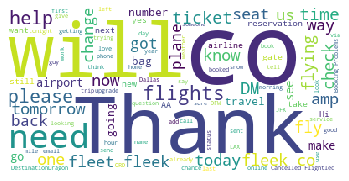

In [7]:
make_wordcloud(neut_text, 'figures/neut_wordcloud.png')

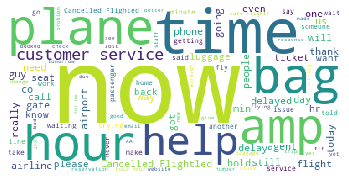

In [8]:
make_wordcloud(neg_text, 'figures/neg_wordcloud.png')

We see clear differences in the word clouds for different classes. The positive class has words like thank, great, and awesome, whereas the negative class has words like now, time, and customer service. These differences hopefully mean that we will be able to use these tweets to correctly classify sentiment.

## --- Baseline ---

In [9]:
df.loc[df['airline_sentiment'] != 'neutral', 'airline_sentiment'].value_counts(normalize = True)

# Remove the neutral class
df = df.loc[df['airline_sentiment'] != 'neutral',]

I will be using f1 score as a metric for this project as the classes are unbalanced so accuracy paints a biased picture. F1 score will always be 50% for random guessing, so our baseline f1 score will be 50%.

I have included the option to balance the dataset (i.e. generate more positive examples in order to have the classes equally represented), but this will not affect the baseline f1 score.

I will not be using the neutral class for this classification as it seems to have little business impact. We would like to be able to know when people are saying good things or bad things about our company, but it shouldn't matter too much if people are saying neutral things about the company.

## --- Clean ---

In [10]:
from sklearn.model_selection import train_test_split
import random

# Split out labels and create train/test sets
train, test = train_test_split(df, test_size=.2, random_state=42)

# Boolean asking if you would like to balance the dataset
# I am only balancing the training set as it may artificially inflate the accuracy to have rows in the test set that are 
# identical to rows in the training set.
balance_dataset = False

if balance_dataset:
    pos = train.loc[df['airline_sentiment'] == 'positive']
    neg = train.loc[df['airline_sentiment'] == 'negative']
    new_pos = pos.sample(neg.shape[0], replace=True, axis=0)
    print(new_pos.shape, pos.shape, neg.shape)
    train = neg.append(new_pos).sample(frac=1)
    
train.shape

(9232, 15)

In [11]:
def split_df(df, keep_cols, reason_cols, drop_cols):
    '''splits the dataframe into 3 by the column lists'''
    df = df.drop_duplicates(subset=keep_cols)
    keep_df = df[keep_cols]
    reason_df = df[reason_cols]
    drop_df = df[drop_cols]
    return keep_df, reason_df, drop_df

keep_cols = ['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence', 'retweet_count', 'text']
reason_cols = ['negativereason', 'negativereason_confidence']
drop_cols = ['airline', 'airline_sentiment_gold', 'name', 'negativereason_gold', 'tweet_coord', 
             'tweet_created', 'tweet_location', 'user_timezone']

It appears there is some issue with American Airlines and duplicate tweets. These tweets are in depth and unlikely to be repeated word for word, so these duplicates should be dropped.

In [12]:
train_keep, train_reason, train_drop = split_df(train, keep_cols, reason_cols, drop_cols)
test_keep, test_reason, test_drop = split_df(test, keep_cols, reason_cols, drop_cols)

train_labels = train_keep.pop('airline_sentiment')
test_labels = test_keep.pop('airline_sentiment')

print(train_labels.value_counts())
print(test_labels.value_counts())

train_keep['text'].head()

negative    7280
positive    1911
Name: airline_sentiment, dtype: int64
negative    1861
positive     446
Name: airline_sentiment, dtype: int64


9498     @USAirways Another dead end.  They only handle...
10811    @USAirways #2066. Was on plane from PBI to CLT...
10831    @USAirways waiting for bags now over 25min in ...
10193    @USAirways Never heard back, but this would he...
1212                                       @united Thanks!
Name: text, dtype: object

There are no numeric columns with range, meaning we do not need to search for outliers. Also, the columns we are currently working with have no NA values, so we do not need to consider dropping rows or imputing values.

Lastly, we remove the neutral class as it is not useful to our business case and will only serve to dilute our training power.

## --- Preprocess Text ---

In [13]:
from nltk.tokenize import word_tokenize
import contractions
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [14]:
from sklearn.base import BaseEstimator, TransformerMixin
from string import punctuation


class TextProcessor(BaseEstimator, TransformerMixin):
    '''preprocceses a list of texts, transforming text to lowercase, removing punctuation and contractions, tokenizing 
    the text, removing stopwords, and lemmatizing the tokens'''
    
    def __init__(self):
        pass
    
    def fit(self):
        return self
    
    def transform(self, corpus):
        corpus = corpus.str.lower()
        corpus = corpus.map(lambda x: ''.join(ch for ch in x if ch not in punctuation))
        corpus = corpus.map(lambda x: contractions.fix(x))
        corpus = corpus.map(word_tokenize)
        corpus = corpus.map(lambda x: [w for w in x if w not in stopwords.words('english')])
        lem = WordNetLemmatizer()
        corpus = corpus.map(lambda x: [lem.lemmatize(w, pos='n') for w in x])
        corpus = corpus.map(lambda x: [lem.lemmatize(w, pos='v') for w in x])
        corpus = corpus.map(lambda x: [lem.lemmatize(w, pos='a') for w in x])
        return corpus

In [15]:
processor = TextProcessor()
train_preprocessed = train_keep.copy()
test_preprocessed = test_keep.copy()
train_tokens = processor.transform(train_keep['text'])
train_preprocessed['text'] = train_tokens
test_tokens = processor.transform(test_keep['text'])
test_preprocessed['text'] = test_tokens
train_preprocessed['text'].head()

9498     [usairways, another, dead, end, handle, aa, la...
10811    [usairways, 2066, plane, pbi, clt, know, freez...
10831       [usairways, wait, bag, 25min, phl, bag, claim]
10193    [usairways, never, hear, back, would, help, ch...
1212                                        [unite, thank]
Name: text, dtype: object

Here we see that our text has been nicely normalized as it is all lowercase, has no punctuation, and has been split into individual tokens and lemmatized into the root words. We have also removed some common English words with little to no predictive power.

## --- Feature Extraction ---

Positive words:
                word  count     ratio
10103          thank   1151  0.400144
561          jetblue   1218  0.126681
6497    southwestair   1418  0.100530
9605           great    245  0.084602
6223            love    172  0.054330
6069   virginamerica    267  0.044584
7235         awesome     90  0.040489
4982            best    129  0.035793
8106            much    162  0.035224
5737           amaze     81  0.033798
Negative words:
             word  count     ratio
2044         call    510 -0.050896
8425          get   1320 -0.051171
4593         hold    536 -0.067020
4042        delay    695 -0.076308
2472       cancel    717 -0.077348
6841        unite   2544 -0.077924
8206  americanair   1900 -0.080632
6821         hour    840 -0.103493
5933    usairways   2095 -0.132522
3372       flight   2540 -0.144100


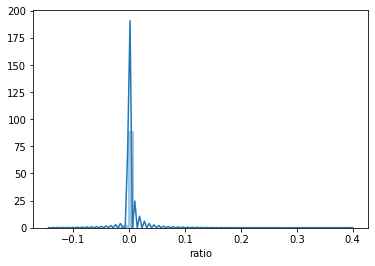

In [16]:
def infrequent_words(word_df, threshhold):
    '''creates a list of words that appear less than the threshhold'''
    return list(word_df.loc[word_df['count'] <= threshhold, 'word'])


def noise_words(word_df, threshhold):
    '''create a list of words whose ratio of positive to negative textx is below the threshhold'''
    return list(word_df.loc[abs(word_df['ratio']) <= threshhold, 'word'])


class RemoveNoise(BaseEstimator, TransformerMixin):
    '''transforms the lists of texts by removing very rare words and words with low predictive power'''
    
    def __init__(self):
        pass
    
    
    def calculate_word_df(self, X, y):
        '''creates a dataframe from the given features and labels with a word column, a count column, and a ratio column'''
        tokenlist = []
        pos_tokens = X.loc[y == 'positive']
        neg_tokens = X.loc[y == 'negative']
        for token_list in X['text']:
            tokenlist.extend(token_list)
        all_tokens = list(set(tokenlist))
        
        pos_percent = {}
        neg_percent = {}
        token_count = []
        ratio = []
        for token in all_tokens:
            token_count.append(sum(X['text'].map(lambda x: token in x)))
            pos_percent[token] = np.mean(pos_tokens['text'].map(lambda x: token in x))
            neg_percent[token] = np.mean(neg_tokens['text'].map(lambda x: token in x))
            ratio.append(pos_percent[token] - neg_percent[token])
    
        word_df = pd.DataFrame({'word': all_tokens, 'count': token_count, 'ratio': ratio})
        return word_df
    
    
    def fit(self, X, y, frequency_thresh, noise_thresh):
        '''creates list of rare words below the frequency threshhold, creates list of words with low predictive 
        power whose ratio is below the noise_threshhold'''
        word_df = self.calculate_word_df(X, y)
        infreq_list = infrequent_words(word_df, frequency_thresh)
        noise_list = noise_words(word_df, noise_thresh)
        self.infreq_list = infreq_list
        self.noise_list = noise_list
        return self
    
    
    def transform(self, X, y=None):
        '''removes words that are rare and have low predictive power'''
        X['text'] = X['text'].map(lambda x: [w for w in x if w not in self.infreq_list])
        X['text'] = X['text'].map(lambda x: [w for w in x if w not in self.noise_list])
        return X

train_tokens = train_preprocessed.copy()
test_tokens = test_preprocessed.copy()
noise_remover = RemoveNoise()
noise_remover.fit(train_tokens, train_labels, 5, 0.002)
noise_remover.transform(train_tokens)

noise_remover.transform(test_tokens)
word_df = noise_remover.calculate_word_df(train_preprocessed, train_labels)
word_df.sort_values('ratio', inplace=True, ascending=False)
sns.distplot(word_df['ratio'])
print("Positive words:")
print(word_df.head(10))
print("Negative words:")
print(word_df.tail(10))

We see that finding the ratio of positive compared to negative reviews seems to have had a great effect! The most highly negative words are words we would expect to find in negative comments about airlines such as cancel and delay, along with airlines that receive more negative comments. The most positive words are words we would expect to be highly positive such as  love and great, alongisde airlines that receive mostly positive comments. Notice how there are a high number of words that have a ratio of 0, which means they are equally represented in the positive and negative reviews. These words are likely not informative to our models and may in fact obscure the important features, so I have removed them. I also removed very rare words, words that appeared less than 5 times in the dataset. This will guard against misspellings and other oddities in the data.

In [17]:
##This cell checks how many empty texts we have and what labels they are given.
train_labels.loc[train_keep['text'].astype(str) == '[]'].value_counts()

Series([], Name: airline_sentiment, dtype: int64)

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer


def dummy_tokenizer(doc):
    '''dummy function necessary for tfidf'''
    return doc

tfidf = TfidfVectorizer(analyzer='word', tokenizer=dummy_tokenizer, preprocessor=dummy_tokenizer, token_pattern=None)
train_doc_word = tfidf.fit_transform(train_tokens['text'])
test_doc_word = tfidf.transform(test_tokens['text'])
train_doc_word.todense()

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

Here I create the document term matrices using tfidf, which represents how commonly a term appears in a document but scaled by how often the term appears across all documents. The reason for this is words that appear in all documents are likely not predictive, so we give higher weight to rarer words.

In [19]:
# One hot encode targets

train_labels.loc[train_labels == 'positive'] = 1
train_labels.loc[train_labels == 'negative'] = 0
train_labels = train_labels.astype('int')

test_labels.loc[test_labels == 'positive'] = 1
test_labels.loc[test_labels == 'negative'] = 0
test_labels = test_labels.astype('int')

In [20]:
from scipy import io
import pickle

# Save matrices and labels to disk
def write_labels(filename, labels):
    '''writes an array of labels to disk'''
    pickle.dump(labels, open(filename, 'wb'))


def write_matrix(filename, mtx):
    '''writes a doc term matrix to disk'''
    io.mmwrite(filename, mtx)
    
write_matrix('data/train_matrix.mtx', train_doc_word)
write_matrix('data/test_matrix.mtx', test_doc_word)
write_labels('data/train_labels.p', train_labels)
write_labels('data/test_labels.p', test_labels)

## --- Build Model ---

In [21]:
def load_matrix(filename):
    '''loads a .mtx file from disk'''
    return io.mmread(filename)


def load_labels(filename):
    '''loads a .p file from disk'''
    return pickle.load(open(filename, 'rb'))

train_matrix = load_matrix('data/train_matrix.mtx')
test_matrix = load_matrix('data/test_matrix.mtx')

from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_validate
from sklearn.ensemble import GradientBoostingClassifier

##This metric will evaluate both the ML and RNN models
metric = 'f1'

multi_clf = MultinomialNB()
gauss_clf = GaussianNB()
gb = GradientBoostingClassifier(max_depth = 5)

multi_cv = cross_validate(multi_clf, train_matrix.toarray(), train_labels, scoring=metric, cv=5, 
                          verbose=5, return_estimator=True)
print(multi_cv['test_score'].mean())

gauss_cv = cross_validate(gauss_clf, train_matrix.toarray(), train_labels, scoring=metric, cv=5, verbose=5,
                         return_estimator=True)
print(gauss_cv['test_score'].mean())

gb_cv = cross_validate(gb, train_matrix, train_labels, scoring=metric, cv=5, verbose=5, 
                       return_estimator=True)
print(gb_cv['test_score'].mean())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV]  ................................................................
[CV] .................................... , score=0.745, total=   0.1s
[CV]  ................................................................
[CV] .................................... , score=0.703, total=   0.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................................... , score=0.702, total=   0.0s
[CV]  ................................................................
[CV] .................................... , score=0.701, total=   0.0s
[CV]  ................................................................
[CV] .................................... , score=0.679, total=   0.0s
0.7057238672890758
[CV]  ................................................................
[CV] .................................... , score=0.505, total=   0.2s
[CV]  ................................................................
[CV] .................................... , score=0.475, total=   0.1s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s


[CV] .................................... , score=0.489, total=   0.2s
[CV]  ................................................................
[CV] .................................... , score=0.491, total=   0.2s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.6s remaining:    0.0s


[CV] .................................... , score=0.472, total=   0.2s
0.4864219454280863
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................................... , score=0.726, total=   2.3s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.2s remaining:    0.0s


[CV] .................................... , score=0.695, total=   2.3s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.6s remaining:    0.0s


[CV] .................................... , score=0.671, total=   2.4s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    6.9s remaining:    0.0s


[CV] .................................... , score=0.695, total=   2.4s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    9.3s remaining:    0.0s


[CV] .................................... , score=0.687, total=   2.4s
0.6948412519584997


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   11.8s finished


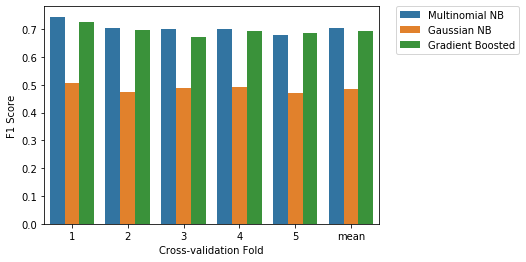

In [22]:
x = [1, 2, 3, 4, 5, 'mean', 1, 2, 3, 4, 5, 'mean', 1, 2, 3, 4, 5, 'mean']
y = list(multi_cv['test_score']) + [multi_cv['test_score'].mean()] + list(gauss_cv['test_score']) + [
    gauss_cv['test_score'].mean()] + list(gb_cv['test_score']) + [gb_cv['test_score'].mean()]
model_name = ['Multinomial NB']*6 + ['Gaussian NB']*6 + ['Gradient Boosted']*6

models_df = pd.DataFrame({'Cross-validation Fold': x, 'F1 Score': y, 'model': model_name})
sns.barplot(x='Cross-validation Fold', y='F1 Score', hue='model', data=models_df)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

I attempted weighting the instances by the label confidence, but that appeared to have no effect on performance and only added model complexity. Also: these models seem to perform worse on the balanced dataset, and if selected should be trained on the original dataset.

Somewhat surprisingly, the multinomial naive bayes model out-performed gradient boosting on this data! It achieved an f1 score of 70%, an increase of 20%.

## --- RNN Model ---

In [ ]:
from itertools import count
from collections import defaultdict
from keras.preprocessing.sequence import pad_sequences


def word_to_id(token_list):
    '''creates a dictionary mapping each unique word to a unique integer id'''
    id_dict = defaultdict((count().__next__))
    for token in token_list:
        id_dict[token] = id_dict[token]
    return id_dict

# Applying embedding after stopwords but before rare/useless words.
train_orig = train_keep.copy()
train_orig['text'] = train_orig['text'].str.lower()
train_orig['text'] = train_orig['text'].map(lambda x: ''.join(ch for ch in x if ch not in punctuation))
train_orig['text'] = train_orig['text'].map(lambda x: contractions.fix(x))
train_orig['text'] = train_orig['text'].map(word_tokenize)

test_orig = test_keep.copy()
test_orig['text'] = test_orig['text'].str.lower()
test_orig['text'] = test_orig['text'].map(lambda x: ''.join(ch for ch in x if ch not in punctuation))
test_orig['text'] = test_orig['text'].map(lambda x: contractions.fix(x))
test_orig['text'] = test_orig['text'].map(word_tokenize)


def tokens_to_sequence(tokens):
    '''takes a dataframe with a "text" column and maps the text column to integers'''
    tokenlist = []
    for token in tokens['text']:
        tokenlist.extend(token)
    id_dict = word_to_id(list(set(tokenlist)))
    print(len(max(tokens['text'], key=len)))
    sequence_list = tokens['text'].map(lambda x: [id_dict[w] + 1 for w in x])
    print(max(id_dict.values()))
    return sequence_list, id_dict

sequence_tokens, id_dict_tokens = tokens_to_sequence(train_tokens)
sequence_preprocess, id_dict_preprocess = tokens_to_sequence(train_preprocessed)
sequence_w_stopwords, id_dict_stopwords = tokens_to_sequence(train_orig)


def test_token_update(tokens, id_dict):
    '''takes a dataframe with a "text" column and a dictionary mapping words to ids. 
    Maps the text column to integers based on said dictionary'''
    sequence_list = tokens['text'].map(lambda x: [id_dict[w] + 1 if w in id_dict.keys() else 0 for w in x])
    return sequence_list


def pad_sequence(sequence):
    '''takes an array of text and pads the sequence with 0s so all inputs are the same length'''
    return pad_sequences(sequence, len(max(sequence, key=len)), 'int', 'post', 'post', 0)


def pad_test_sequence(sequence, train_sequence):
    '''takes an array of text and a padded sequence, pads the array of text to the same length as the padded sequence'''
    return pad_sequences(sequence, len(max(train_sequence, key=len)), 'int', 'post', 'post', 0)

sequence_tokens = pad_sequence(sequence_tokens)
sequence_preprocess = pad_sequence(sequence_preprocess)
sequence_w_stopwords = pad_sequence(sequence_w_stopwords)

test_token_sequence = test_token_update(test_tokens, id_dict_tokens)
test_pre_sequence = test_token_update(test_preprocessed, id_dict_preprocess)
test_stop_sequence = test_token_update(test_orig, id_dict_stopwords)

test_token_sequence = pad_test_sequence(test_token_sequence, sequence_tokens)
test_pre_sequence = pad_test_sequence(test_pre_sequence, sequence_preprocess)
test_stop_sequence = pad_test_sequence(test_stop_sequence, sequence_w_stopwords)

Using TensorFlow backend.


In [ ]:
sequence_tokens

Here I create the sequences that will be fed into the RNNs. I will be training 3 RNNs: one model on the tokens used in the other models, one model on the tokens before rare and neutral words were removed, and one model on the tokens before stopwords were removed. The test data is then put through the same process and to avoid test leakage, any words appearing in the test set that did not appear in the train set are not encoded and therefore are dropped.

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import optimizers


def build_train_model(sequence, y, id_dict, embedding_size, lstm_size,
                      dropout, epochs, batch_size, filename):
    '''trains an RNN. takes a sequence of inputs, an array of labels, a dictionary mapping words to integers, 
    the size of the embedding and LSTM layers, the dropout rate, the number of epochs, the batch_size, and the 
    filename to save the model to.'''
    model = Sequential()
    
    model.add(Embedding(max(id_dict.values()) + 2, embedding_size, mask_zero=True, 
                        input_length=len(max(sequence, key=len))))
    model.add(LSTM(lstm_size, activation='tanh', recurrent_activation='sigmoid', dropout=dropout, use_bias=True, 
                   unit_forget_bias=True))
    model.add(Dense(1, activation='sigmoid', use_bias=True))
    model.add(Dropout(0.2))
    
    adam = optimizers.Adam(learning_rate=0.0001)
    
    model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
    
    es = EarlyStopping(monitor=('val_accuracy'), mode='max', verbose=1, patience=10)
    mc = ModelCheckpoint(filename, monitor='val_accuracy', save_best_only=True)
    
    history = model.fit(x=sequence, y=y, batch_size=batch_size, epochs=epochs, 
                        verbose=1, validation_split=.2, callbacks=[es, mc])
    
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='test')
    plt.legend()
    plt.show()
    
y = train_labels
embedding_size = 100
LSTM_size = 128
dropout = .2
epochs = 50
batch_size = 100

build_train_model(sequence_tokens, y, id_dict_tokens, embedding_size, LSTM_size,
                  dropout, epochs, batch_size, 'models/token.h5')
build_train_model(sequence_preprocess, y, id_dict_preprocess, embedding_size, LSTM_size, dropout, epochs, 
                  batch_size, 'models/preprocess.h5')
build_train_model(sequence_w_stopwords, y, id_dict_stopwords, embedding_size, LSTM_size, dropout, epochs, 
                  batch_size, 'models/stopwords.h5')

The RNN models seem extremely promising, with all 3 achieving a validation accuracy of 96%, a huge boost over the other machine learning models. Note that this does not compare directly with the other models validation scores as I have used accuracy instead of f1 score. The reason for this is it is difficult to implement f1 score in keras, however I will evaluate the f1 score on the test data to get a comparison against the traditional machine learning models.

The models did not gain any benefit from weighting the instances by their label confidence. However, balancing the dataset leads to highly inflated validation accuracy (as there are duplicate instances in the validation set) but no real affect on the test accuracy, which leads me to believe we should not be balancing the training data.

The model is very easily scalable and would likely continue to improve with larger data sources. The RNN's can be scaled to larger vocabularies by increasing the size of the embedding layer and can be scaled to more instances by increasing the size of the LSTM layer.

In [ ]:
from sklearn.metrics import f1_score
from keras.models import load_model

print('Multinomial NB:', f1_score(test_labels, multi_cv['estimator'][0].predict(test_matrix.toarray())))
print('Gaussian NB:', f1_score(test_labels, gauss_cv['estimator'][0].predict(test_matrix.toarray())))
print('Gradient Boosted:', f1_score(test_labels, gb_cv['estimator'][0].predict(test_matrix.toarray())))

token_model = load_model('models/token.h5')
preprocess_model = load_model('models/preprocess.h5')
stopword_model = load_model('models/stopwords.h5')

print('RNN with tokens:', f1_score(test_labels, pd.Series(token_model.predict(test_token_sequence).flatten()).map(round)))
print('RNN with preprocessed:', f1_score(test_labels, pd.Series(preprocess_model.predict(test_pre_sequence).flatten()).map(round)))
print('RNN with stopwords:', f1_score(test_labels, pd.Series(stopword_model.predict(test_stop_sequence).flatten()).map(round)))

On the test data, the RNN model with stopwords performs best, beating out other models by almost 4 percentage points. All 3 RNN models outperform all 3 traditional machine learning models, indicating that the RNN models are likely superior.

In [ ]:
models = ['Multinomial NB', 'Gaussian NB', 'Gradient Boosted', 'Token RNN', 'Rare Word RNN', 'Stopword RNN']
scores = [f1_score(test_labels, multi_cv['estimator'][0].predict(test_matrix.toarray())),
          f1_score(test_labels, gauss_cv['estimator'][0].predict(test_matrix.toarray())),
          f1_score(test_labels, gb_cv['estimator'][0].predict(test_matrix.toarray())),
          f1_score(test_labels, pd.Series(token_model.predict(test_token_sequence).flatten()).map(round)),
          f1_score(test_labels, pd.Series(preprocess_model.predict(test_pre_sequence).flatten()).map(round)),
          f1_score(test_labels, pd.Series(stopword_model.predict(test_stop_sequence).flatten()).map(round))]
score_model_df = pd.DataFrame({'Model':models,'F1 Score':scores})

In [ ]:
sns.barplot(x='Model', y='F1 Score', data=score_model_df)
plt.xticks(rotation=45)